In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (3178).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (3561).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (900).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1148).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (268).jpg
/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S

# import Libraries 

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from sklearn.metrics import roc_curve, auc
import matplotlib.image as mpimg
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout , Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import random
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2025-12-17 21:23:10.669864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766006590.822405      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766006590.867023      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766006591.234688      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766006591.234742      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766006591.234744      55 computation_placer.cc:177] computation placer alr

In [3]:
base_dir = r'/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'


In [4]:
classes = ['Cyst', 'Tumor', 'Stone', 'Normal']


In [5]:
data = []
for label in classes:
    folder_path = os.path.join(base_dir, label)
    for file in os.listdir(folder_path):
        if file.endswith(('jpg')):  
            file_path = os.path.join(folder_path, file)
            data.append((file_path, label))

In [6]:
df = pd.DataFrame(data, columns=['file_path', 'label'])

In [7]:
df.head()

,file_path,label
0,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst
1,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst
2,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst
3,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst
4,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst


In [8]:
df.shape

(12446, 2)

In [9]:
df['label'].value_counts()

label
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64

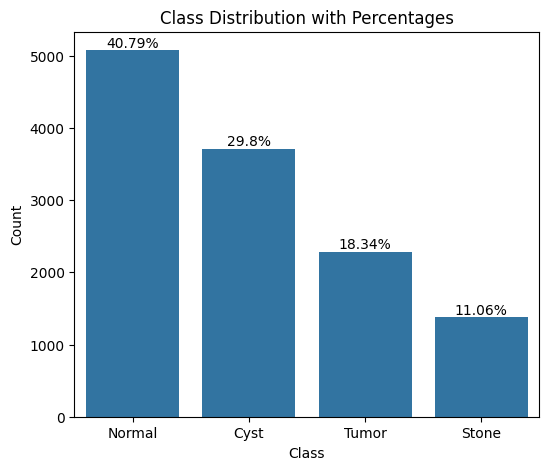

In [10]:
value_counts = df['label'].value_counts().reset_index()
value_counts.columns = ['label', 'count']
value_counts['percentage'] = (value_counts['count'] / value_counts['count'].sum() * 100).round(2)
plt.figure(figsize=(6,5))
ax = sns.barplot(data=value_counts, x='label', y='count')
for i, row in value_counts.iterrows():
    ax.text(i, row['count'], f"{row['percentage']}%", ha='center', va='bottom', fontsize=10, color='black')

plt.title("Class Distribution with Percentages")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

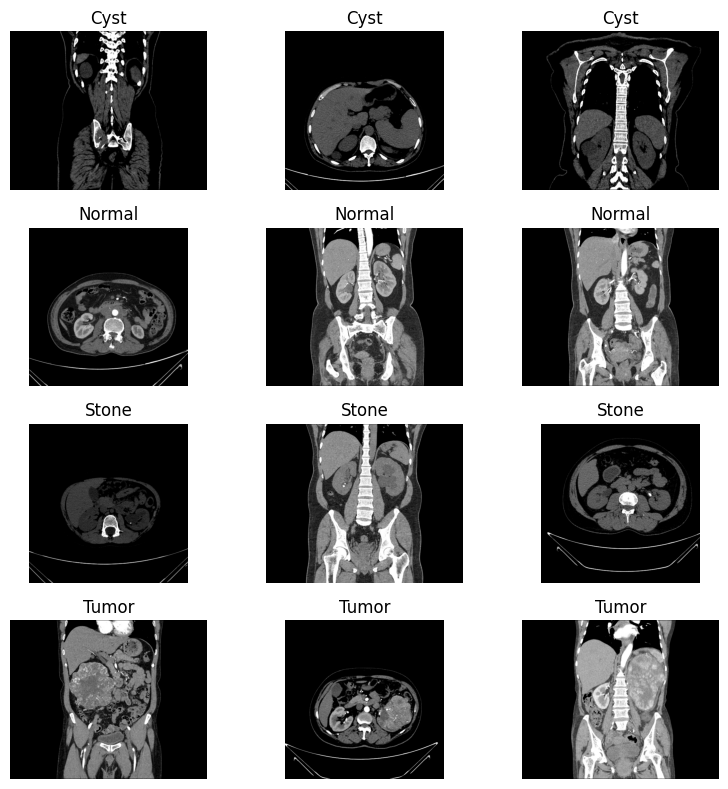

In [11]:
classes_to_display = ['Cyst', 'Normal', 'Stone', 'Tumor']
fig, axes = plt.subplots(4, 3, figsize=(8, 8))  
axes = axes.flatten()  

for i, label in enumerate(classes_to_display):
    class_data = df[df['label'] == label]
    sample_images = random.sample(list(class_data['file_path']), 3)
    
    for j, img_path in enumerate(sample_images):
        img = mpimg.imread(img_path) 
        axes[i * 3 + j].imshow(img)  
        axes[i * 3 + j].axis('off')  
        axes[i * 3 + j].set_title(label)  
plt.tight_layout()
plt.show()

In [12]:
df['binary_label'] = df['label'].apply(lambda x: 0 if x == 'Normal' else 1)


In [13]:
df.head()

,file_path,label,binary_label
0,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1
1,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1
2,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1
3,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1
4,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1


In [14]:
df['binary_label'].value_counts()


binary_label
1    7369
0    5077
Name: count, dtype: int64

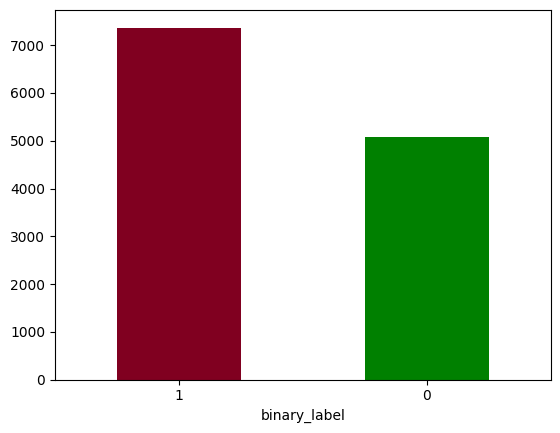

In [15]:
value_counts = df['binary_label'].value_counts()
ax = value_counts.plot(kind='bar', color=['#800020', 'green'])
plt.xticks(rotation=360)
plt.grid(False)

plt.show()


In [16]:
df['label'].value_counts()


label
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64

# undersampling 

> ***tyr to make the data balanced***
> 
> ***delete from the cyst categroy 1500 image to make normal and upnormal close to each other***

In [17]:
df = df.drop(df[df['label'] == 'Cyst'].head(1500).index)

In [18]:
df['label'].value_counts()

label
Normal    5077
Tumor     2283
Cyst      2209
Stone     1377
Name: count, dtype: int64

In [19]:
df['binary_label'].value_counts()

binary_label
1    5869
0    5077
Name: count, dtype: int64

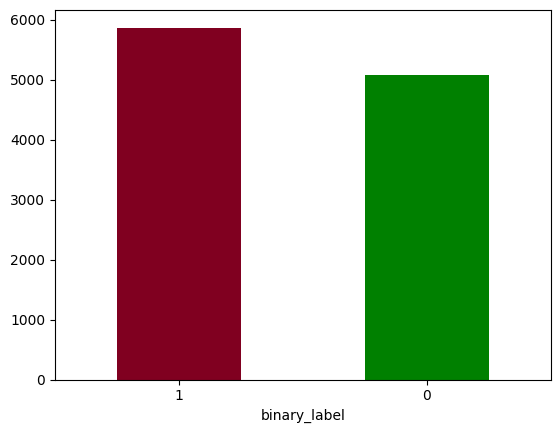

In [20]:
value_counts = df['binary_label'].value_counts()
ax = value_counts.plot(kind='bar', color=['#800020', 'green'])
plt.xticks(rotation=360)
plt.grid(False)

plt.show()


# image processing 

# split data

***split data into train 90% , val 5% , test 5%***


In [21]:
train_df, temp_df = train_test_split(df, test_size=0.1, stratify=df['binary_label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['binary_label'], random_state=42)

In [22]:
print(f"Training size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Testing size: {len(test_df)}")

Training size: 9851
Validation size: 547
Testing size: 548


In [23]:
train_df

,file_path,label,binary_label
9398,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Normal,0
2554,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1
5121,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Tumor,1
2002,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1
7494,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Normal,0
...,...,...,...
10772,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Normal,0
9335,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Normal,0
10051,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Normal,0
4311,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Tumor,1


In [24]:
train_df['binary_label'].value_counts()

binary_label
1    5282
0    4569
Name: count, dtype: int64

# preprocessing 

In [25]:
train_df['binary_label'] = train_df['binary_label'].astype(str)
val_df['binary_label'] = val_df['binary_label'].astype(str)
test_df['binary_label'] = test_df['binary_label'].astype(str)

In [26]:
def to_grayscale(img):
    if img.shape[-1] == 3:      
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif img.shape[-1] == 1:     
        gray = img.squeeze(-1)
    else:
        raise ValueError(f"Unexpected number of channels: {img.shape[-1]}")
    gray = np.expand_dims(gray, axis=-1)  
    return gray.astype(np.float32)

In [27]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,          
    width_shift_range=0.05,     
    height_shift_range=0.05,
    zoom_range=0.05,             
    horizontal_flip=False,       
    fill_mode='nearest',
    preprocessing_function=to_grayscale
)

In [28]:
datagen = ImageDataGenerator(rescale=1.0/255,
                            preprocessing_function=to_grayscale)

In [29]:
binary_train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='binary_label',
    target_size=(224, 224),
    color_mode='grayscale',    
    batch_size=64,
    class_mode='binary',
    shuffle=True
)

Found 9851 validated image filenames belonging to 2 classes.


In [30]:
binary_val_gen = datagen.flow_from_dataframe(
    val_df,
    x_col='file_path',
    y_col='binary_label',
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=64,
    class_mode='binary'
)

Found 547 validated image filenames belonging to 2 classes.


In [31]:
binary_test_gen = datagen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='binary_label',
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 548 validated image filenames belonging to 2 classes.


# model 

> ***binary model*** 

> i have input shape that (22, 224 , 1 ) 
 
> 5 CNN layers

> 2 ANN layers

> binary output with sigmoid function

In [32]:
binary_model = models.Sequential([
    layers.Input(shape=(224, 224, 1)),
    layers.Conv2D(16, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(32, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(128, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


I0000 00:00:1766006608.451109      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [33]:
binary_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,321 (2.47 MB)

 Trainable params: 648,321 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
binary_model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [36]:
classes = np.unique(train_df['binary_label'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_df['binary_label']
)

class_weight_dict = dict(zip(classes, class_weights))
print(class_weight_dict)


{'0': np.float64(1.0780258262201794), '1': np.float64(0.932506626277925)}


In [37]:
history = binary_model.fit(
    binary_train_gen,
    epochs=20,
    validation_data=binary_val_gen,
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1766006613.975055     123 service.cc:152] XLA service 0x7d987c0089e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766006613.975094     123 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766006614.601718     123 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/154 ━━━━━━━━━━━━━━━━━━━━ 26:26 10s/step - accuracy: 0.4375 - loss: 0.6951

I0000 00:00:1766006621.505357     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


154/154 ━━━━━━━━━━━━━━━━━━━━ 111s 661ms/step - accuracy: 0.5780 - loss: 0.6636 - val_accuracy: 0.7477 - val_loss: 0.5257
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 66s 427ms/step - accuracy: 0.7937 - loss: 0.4606 - val_accuracy: 0.8044 - val_loss: 0.4586
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 65s 422ms/step - accuracy: 0.8172 - loss: 0.4237 - val_accuracy: 0.7751 - val_loss: 0.4629
Epoch 4/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 65s 425ms/step - accuracy: 0.8174 - loss: 0.4012 - val_accuracy: 0.8135 - val_loss: 0.3965
Epoch 5/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 66s 430ms/step - accuracy: 0.8423 - loss: 0.3582 - val_accuracy: 0.8940 - val_loss: 0.3473
Epoch 6/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 66s 425ms/step - accuracy: 0.8702 - loss: 0.3052 - val_accuracy: 0.8739 - val_loss: 0.3248
Epoch 7/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 65s 421ms/step - accuracy: 0.8799 - loss: 0.2844 - val_accuracy: 0.8921 - val_loss: 0.2781
Epoch 8/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 64s 417ms/step - accuracy: 0.8974 - loss: 0.2512 - va

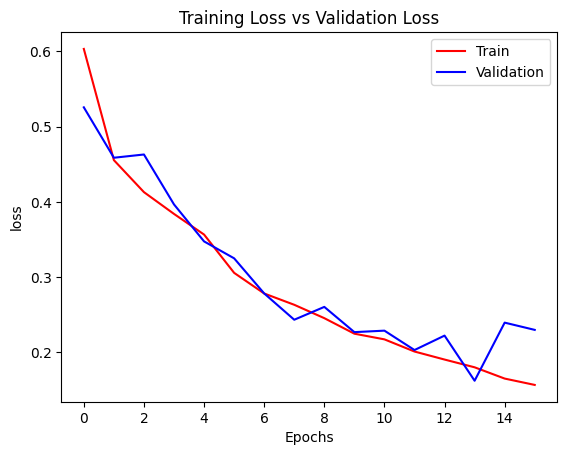

In [38]:
plt.title('Training Loss vs Validation Loss')
plt.plot(history.history['loss'], color='red', label='Train')
plt.plot(history.history['val_loss'], color='blue', label='Validation')

plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

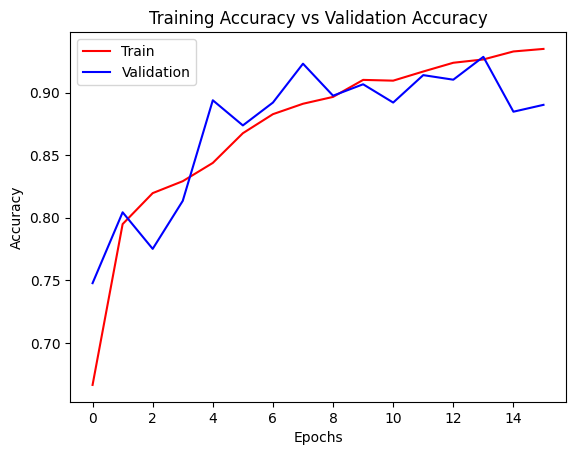

In [39]:
plt.title('Training Accuracy vs Validation Accuracy')
plt.plot(history.history['accuracy'], color='red', label='Train')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

> ***evaluation***

In [40]:
test_loss_binary, test_accuracy_binary = binary_model.evaluate(binary_test_gen)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 480ms/step - accuracy: 0.9459 - loss: 0.1639


In [41]:
print(f"Loss: {test_loss_binary}")
print(f"Accuracy: {test_accuracy_binary}")

Loss: 0.15244600176811218
Accuracy: 0.9525547623634338


In [86]:
y_pred_prob = binary_model.predict(binary_test_gen)  


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step


In [87]:
y_true = binary_test_gen.classes

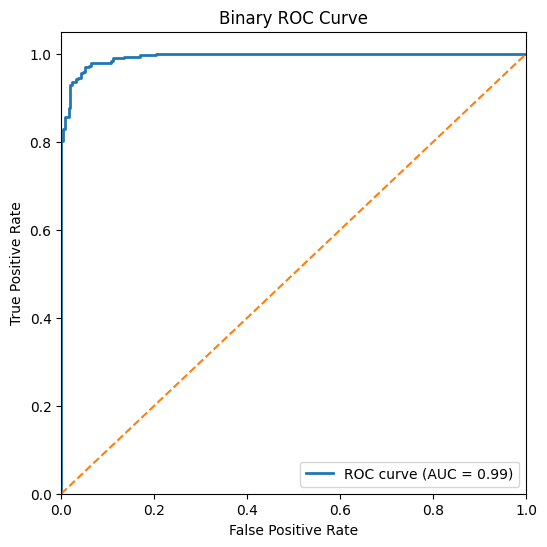

In [88]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [46]:
y_pred = (y_pred_prob > 0.5).astype(int)

In [47]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95       254
           1       0.94      0.98      0.96       294

    accuracy                           0.95       548
   macro avg       0.96      0.95      0.95       548
weighted avg       0.95      0.95      0.95       548



In [48]:
cm = confusion_matrix(y_true, y_pred)

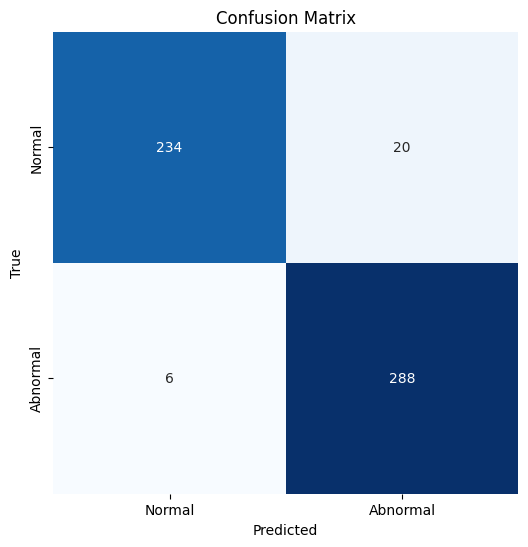

In [49]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

> ***classification model***

In [50]:
abnormal_df = df[df['label'].isin(['Cyst', 'Stone', 'Tumor'])]

In [51]:
abnormal_df.head()

,file_path,label,binary_label
1500,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1
1501,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1
1502,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1
1503,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1
1504,/kaggle/input/ct-kidney-dataset-normal-cyst-tu...,Cyst,1


In [52]:
abnormal_df.shape

(5869, 3)

In [53]:
abnormal_df['label'].value_counts()

label
Tumor    2283
Cyst     2209
Stone    1377
Name: count, dtype: int64

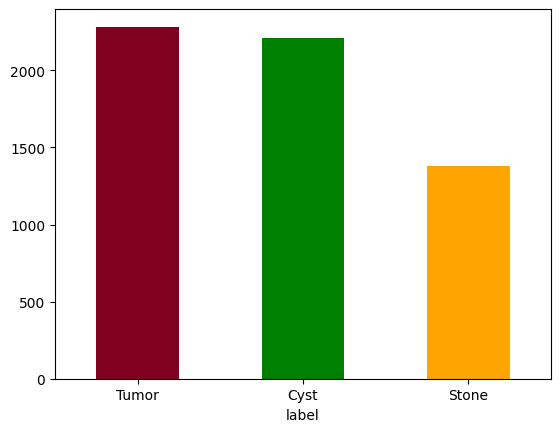

In [54]:
value_counts = abnormal_df['label'].value_counts()
ax = value_counts.plot(kind='bar', color=['#800020', 'green','orange'])
plt.xticks(rotation=360)
plt.grid(False)

plt.show()


In [55]:
train_abnormal_df, temp_df = train_test_split(abnormal_df, test_size=0.1, stratify=abnormal_df['label'], random_state=42)
val_abnormal_df, test_abnormal_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [56]:
print(f"Training size: {len(train_abnormal_df)}")
print(f"Validation size: {len(val_abnormal_df)}")
print(f"Testing size: {len(test_abnormal_df)}")

Training size: 5282
Validation size: 293
Testing size: 294


In [57]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    preprocessing_function=to_grayscale
)


In [58]:
multiclass_train_gen = train_datagen.flow_from_dataframe(
    train_abnormal_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical'
)

Found 5282 validated image filenames belonging to 3 classes.


In [59]:
multiclass_val_gen = datagen.flow_from_dataframe(
    val_abnormal_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical'
)

Found 293 validated image filenames belonging to 3 classes.


In [60]:
multiclass_test_gen = datagen.flow_from_dataframe(
    test_abnormal_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 294 validated image filenames belonging to 3 classes.


In [61]:
multiclass_model = models.Sequential([
    layers.Input(shape=(224, 224, 1)),
    layers.Conv2D(16, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
   
    layers.Conv2D(128, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu' , padding = 'same'), 
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax')
])

In [62]:
multiclass_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,387 (2.47 MB)

 Trainable params: 648,387 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
multiclass_model.compile(optimizer=Adam(learning_rate=0.0001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [64]:
history= multiclass_model.fit(multiclass_train_gen,
                     validation_data=multiclass_val_gen,
                     epochs=20,
                     class_weight=class_weight_dict
                             )

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 483ms/step - accuracy: 0.4596 - loss: 1.0532 - val_accuracy: 0.6280 - val_loss: 0.8303
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 434ms/step - accuracy: 0.6254 - loss: 0.7968 - val_accuracy: 0.6894 - val_loss: 0.6734
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 438ms/step - accuracy: 0.7077 - loss: 0.6632 - val_accuracy: 0.7543 - val_loss: 0.5439
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 432ms/step - accuracy: 0.7765 - loss: 0.5226 - val_accuracy: 0.8157 - val_loss: 0.4146
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 431ms/step - accuracy: 0.8220 - loss: 0.4262 - val_accuracy: 0.8601 - val_loss: 0.3722
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 428ms/step - accuracy: 0.8543 - loss: 0.3678 - val_accuracy: 0.8123 - val_loss: 0.4071
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 35s 426ms/step - accuracy: 0.8532 - loss: 0.3520 - val_accuracy: 0.9044 - val_loss: 0.2242
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 35s 427ms/step - accuracy: 0.8933 - loss: 0.2860 - val_accu

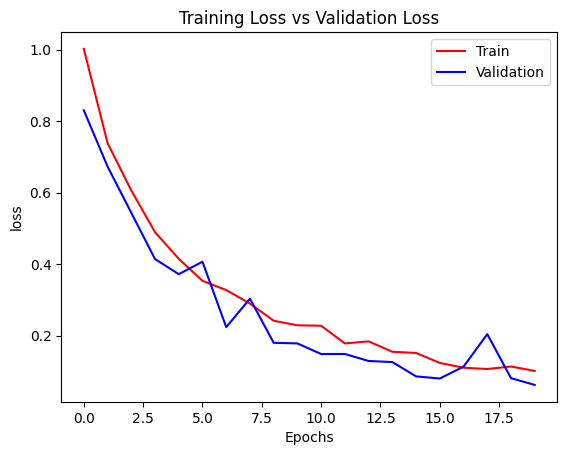

In [65]:
plt.title('Training Loss vs Validation Loss')
plt.plot(history.history['loss'], color='red', label='Train')
plt.plot(history.history['val_loss'], color='blue', label='Validation')

plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

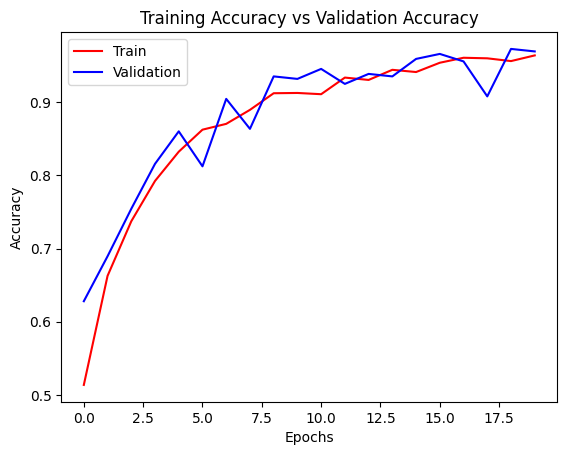

In [66]:
plt.title('Training Accuracy vs Validation Accuracy')
plt.plot(history.history['accuracy'], color='red', label='Train')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

> evalution 

In [67]:
test_loss_multi, test_accuracy_multi = multiclass_model.evaluate(multiclass_test_gen)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step - accuracy: 0.9559 - loss: 0.0951


In [68]:
print(f"Loss: {test_loss_multi}")
print(f"Accuracy: {test_accuracy_multi}")


Loss: 0.10201200097799301
Accuracy: 0.9523809552192688


In [69]:
y_pred_probs = multiclass_model.predict(multiclass_test_gen) 

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step


In [70]:
y_pred = y_pred_probs.argmax(axis=1)

In [71]:
y_true = multiclass_test_gen.classes  
y_true_oh = to_categorical(y_true, num_classes=3)

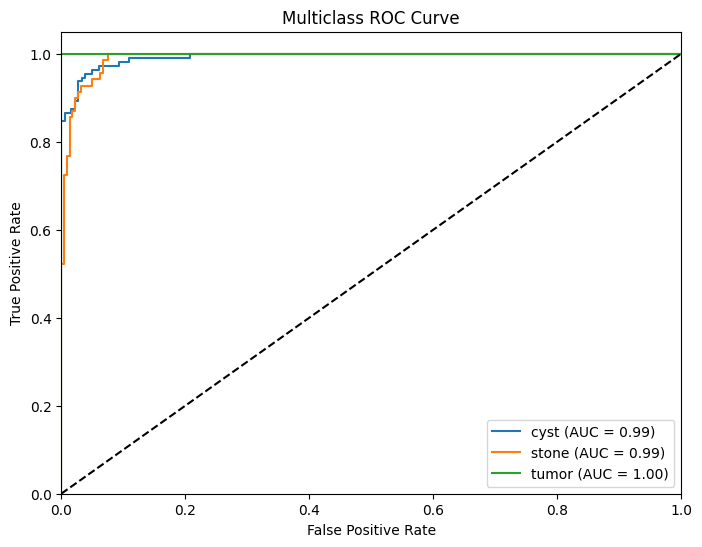

In [73]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true_oh[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(8, 6))

class_names = ['cyst', 'stone', 'tumor']  

for i in range(3):
    plt.plot(
        fpr[i],
        tpr[i],
        label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})'
    )

plt.plot([0, 1], [0, 1], 'k--')  # random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()


**0: cyst , 1: stone , 2 : tumor**

In [74]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       111
           1       0.88      0.93      0.90        69
           2       1.00      1.00      1.00       114

    accuracy                           0.95       294
   macro avg       0.94      0.95      0.95       294
weighted avg       0.95      0.95      0.95       294



In [76]:
cm = confusion_matrix(y_true, y_pred)

In [77]:
class_names = list(multiclass_test_gen.class_indices.keys())

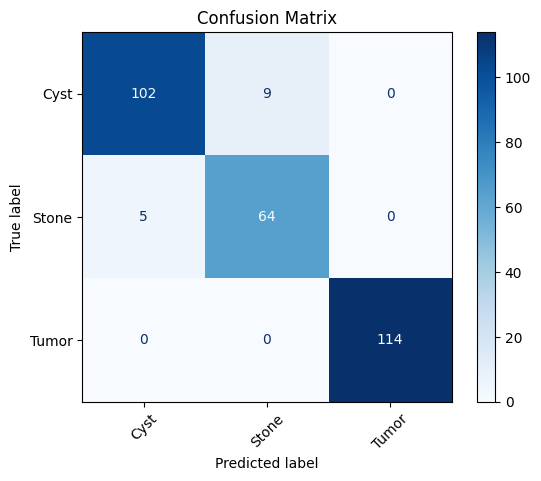

In [78]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

# save models 

In [79]:
multiclass_model.save('multiclass_model_final.h5')
binary_model.save('binary_model_final.h5')

# prediction function

In [80]:
binary_model = load_model('binary_model_final.h5')
multiclass_model = load_model('multiclass_model_final.h5')

In [84]:
def predict_pipeline(image_path, binary_model, multiclass_model):
    img = load_img(image_path, target_size=(224, 224) ,  color_mode='grayscale')  
    img_array = img_to_array(img) / 255.0 
    img_array = np.expand_dims(img_array, axis=0)  
    
    binary_pred = binary_model.predict(img_array)
    if binary_pred > 0.5:
        multiclass_pred = multiclass_model.predict(img_array)
        class_idx = np.argmax(multiclass_pred) 
        
        class_labels = {0: 'Cyst', 1: 'Stone', 2: 'Tumor'}
        return f"Abnormal: {class_labels[class_idx]}"
    else:
        return "Normal"

In [85]:
image_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (10).jpg"
result = predict_pipeline(image_path, binary_model, multiclass_model)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Normal
